# Dummy Model regression

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from statsmodels.tools.eval_measures import stde


## Read the etl info results

In [4]:
df_info = pd.read_csv('../dataset_clean/options_csv_v1_etl.csv')
df_info

,remove_time_features,generic_features,remove_atypical_values,feature_combination,remove_feature_selection,remove_invalid_correlated_features
0,True,True,False,degree 2 polynomial,False,False


## Read the dataset

In [8]:
df = pd.read_csv('../dataset/2012_2019_PlatteRiverWeir_features_merged_all.csv')
df

,Unnamed: 0,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,CalcTimestamp,...,WeirPt2X,WeirPt2Y,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma
0,0,2012-06-09 13:15:00,2012-06-09T13:09:07,StateLineWeir_20120609_Farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:28,...,-1,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,1,2012-06-09 13:15:00,2012-06-09T13:10:29,StateLineWeir_20120609_Farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:33,...,-1,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,2,2012-06-09 13:45:00,2012-06-09T13:44:01,StateLineWeir_20120609_Farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,2020-03-11T16:58:40,...,-1,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,3,2012-06-09 14:45:00,2012-06-09T14:44:30,StateLineWeir_20120609_Farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:47,...,-1,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,4,2012-06-09 15:45:00,2012-06-09T15:44:59,StateLineWeir_20120609_Farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:55,...,-1,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42054,42054,2019-10-11 09:00:00,2019-10-11T08:59:53,StateLineWeir_20191011_Farrell_409.jpg,USGS,6674500,MDT,2.54,434.0,2020-03-12T16:23:53,...,2446,1900,9284.0,77521.0,38385.370066,15952.029728,0.0,70085.0,37550.894823,16444.401209
42055,42055,2019-10-11 10:00:00,2019-10-11T09:59:52,StateLineWeir_20191011_Farrell_410.jpg,USGS,6674500,MDT,2.54,434.0,2020-03-12T16:23:54,...,2440,1900,10092.0,74614.0,40162.989292,15467.708856,0.0,70061.0,39397.339095,16009.008049
42056,42056,2019-10-11 11:00:00,2019-10-11T10:59:52,StateLineWeir_20191011_Farrell_411.jpg,USGS,6674500,MDT,2.54,434.0,2020-03-12T16:23:55,...,2447,1900,7067.0,83260.0,42095.946590,16770.357949,0.0,76335.0,41350.006568,17489.374617
42057,42057,2019-10-11 12:00:00,2019-10-11T11:59:53,StateLineWeir_20191011_Farrell_412.jpg,USGS,6674500,MDT,2.54,434.0,2020-03-12T16:23:56,...,2443,1900,6283.0,83045.0,45345.490954,17498.432849,0.0,78882.0,44553.920296,18268.294896


In [9]:
df['SensorTime'] = pd.to_datetime(df['SensorTime'])
df['Year'] = df['SensorTime'].dt.year
df['Month'] = df['SensorTime'].dt.month

In [10]:
df.dtypes

Unnamed: 0                   int64
SensorTime          datetime64[ns]
CaptureTime                 object
Filename                    object
Agency                      object
                         ...      
WwCurveLineMax             float64
WwCurveLineMean            float64
WwCurveLineSigma           float64
Year                         int64
Month                        int64
Length: 62, dtype: object

### Remove outliers (values equal to zero seem to be incorrect looking at the images)

In [11]:
df = df[(df.Stage > 0) & (df.Discharge > 0)]

## Divide dataset to X and Y

In [12]:
df_train = df[(df.Year >= 2012) & (df.Year <= 2017)]
df_test = df[(df.Year >= 2018) & (df.Year <= 2019)]

In [13]:
df_train = df_train.drop(columns=["Year", "SensorTime", "CaptureTime"])
df_test = df_test.drop(columns=["Year", "SensorTime", "CaptureTime"])

In [14]:
y_train = df_train[["Stage", "Discharge"]]
X_train = df_train.drop(columns=["Stage", "Discharge"])
y_test = df_test[["Stage", "Discharge"]]
X_test = df_test.drop(columns=["Stage", "Discharge"])

In [15]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

## Train normal model

### Train model

In [16]:
dummy_regr = DummyRegressor(strategy="mean", quantile=0.4)

In [17]:
dummy_regr.fit(X_train, y_train)

DummyRegressor(quantile=0.4)

### Test model

In [18]:
dummy_regr.score(X_test, y_test)


-0.2023890547194146

In [19]:
y_pred = dummy_regr.predict(X_test)

In [20]:
def evaluation_of_model(y_real, y_predictions):
      print("R^2: ", r2_score(y_real, y_predictions))
      print("mse: ", mean_squared_error(y_real, y_predictions))
      print("rmse: ", mean_squared_error(y_real, y_predictions, squared=False))
      print("mae: ", mean_absolute_error(y_real, y_predictions))
      print("mape: ", mean_absolute_percentage_error(y_real, y_predictions))
      print("Error estandar: ", stde(y_real.squeeze(),
            y_predictions.squeeze(), ddof=2))


In [21]:
evaluation_of_model(y_test, y_pred)

R^2:  -0.2023890547194146
mse:  358624.66836268915
rmse:  423.78945528495314
mae:  370.77397691898614
mape:  1.7861659223930955
Error estandar:  [6.24980271e-01 7.59525461e+02]


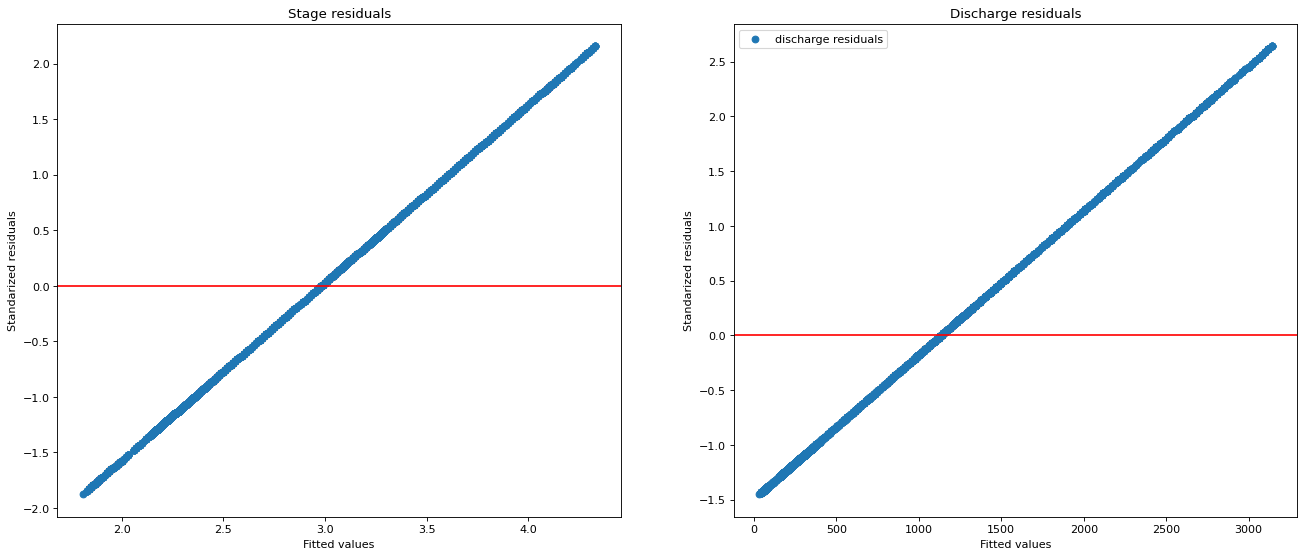

In [22]:
residuals = y_test - y_pred
residuals_std = residuals/residuals.std()

y_real_stage = y_test.Stage
residual_stage = residuals.Stage

y_real_discharge = y_test.Discharge
residual_discharge = residuals.Discharge


figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[0].scatter(y_real_stage, residual_stage / residual_stage.std(), label="stage residuals")
ax[1].scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")
ax[0].axhline(y=0.0, color='r', linestyle='-')
ax[1].axhline(y=0.0, color='r', linestyle='-')

ax[0].set_title("Stage residuals")
ax[1].set_title("Discharge residuals")

ax[0].set_xlabel("Fitted values")
ax[1].set_xlabel("Fitted values")
ax[0].set_ylabel("Standarized residuals")
ax[1].set_ylabel("Standarized residuals")

plt.legend()
plt.show()

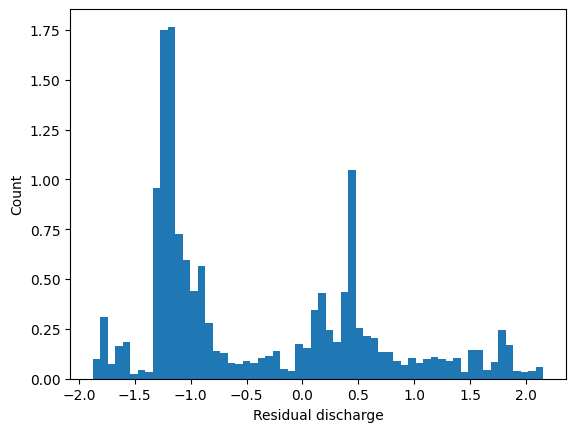

In [23]:
plt.hist(residual_stage / residual_stage.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual discharge');
plt.show()

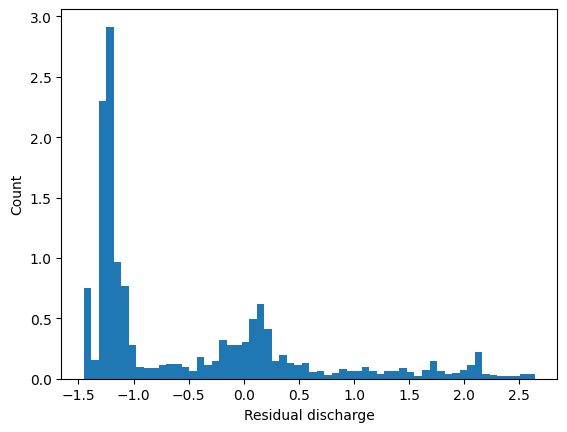

In [24]:
plt.hist(residual_discharge / residual_discharge.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual discharge');
plt.show()

## Train model based on months

### Train model

In [25]:
dummy_regr = DummyRegressor(strategy="quantile", quantile=0.4)

In [26]:
predictions = np.array([[0, 0]])
real_values = np.array([[0, 0]])

In [27]:
for i in range(1, 13):
    # select data
    train_month = df_train[df_train["Month"] == i]
    y_train = train_month[["Stage", "Discharge"]]
    X_train = train_month.drop(columns=["Stage", "Discharge"])
    test_month = df_test[df_test["Month"] == i]
    y_test = test_month[["Stage", "Discharge"]]
    X_test = test_month.drop(columns=["Stage", "Discharge"])
    # train model

    dummy_regr.fit(X_train, y_train)

    print(dummy_regr.score(X_test, y_test))

    y_pred = dummy_regr.predict(X_test)

    predictions = np.concatenate((predictions, y_pred), axis=0)
    real_values = np.concatenate((real_values, y_test.values), axis=0)

-8.401248826753704
-30.085530576688647
-0.35432415795223793
-0.21035053828734984
-4.529507349976571
-0.5534353179458261
-0.2614690159954942
-0.4890710606834685
-0.004060262940739134
-0.017556964258563346
-5.965946207741071
-7.486863941536578


### Evaluate model

In [28]:
evaluation_of_model(real_values, predictions)


R^2:  0.43734749614059554
mse:  164998.7306352373
rmse:  287.4594974781066
mae:  176.8961792897548
mape:  0.692042133541478
Error estandar:  [4.56403538e-01 5.68520950e+02]


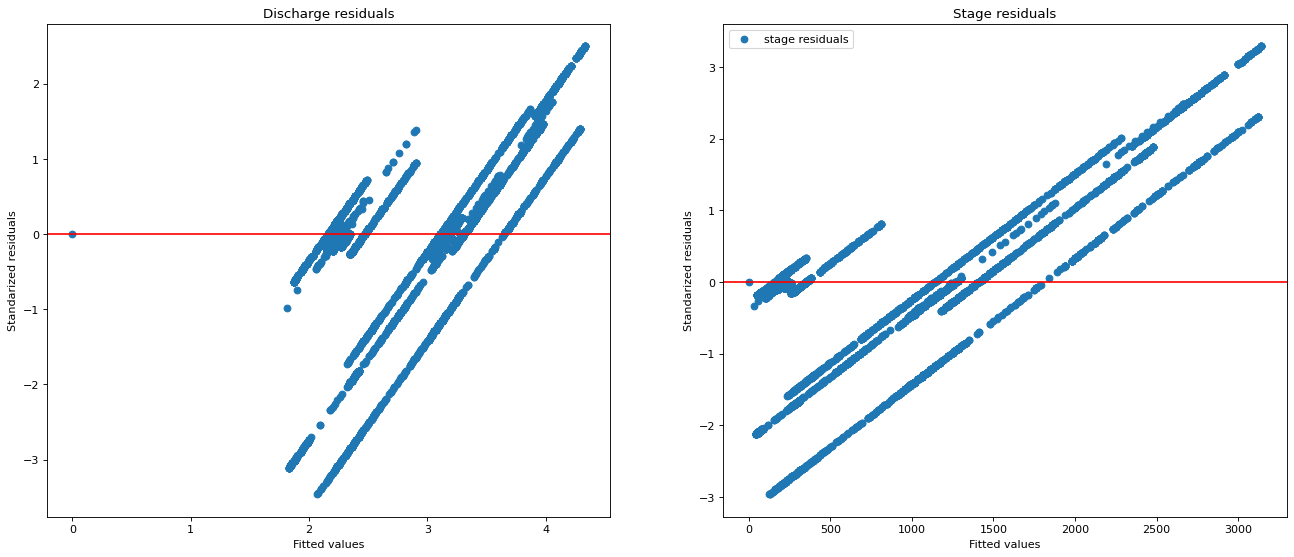

In [29]:
residuals = real_values - predictions
residuals_std = residuals/residuals.std()

y_real_stage = np.array([i[-1] for i in real_values])
residual_stage = np.array([i[-1] for i in residuals])

y_real_discharge = np.array([i[0] for i in real_values])
residual_discharge = np.array([i[0] for i in residuals])


figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[1].scatter(y_real_stage, residual_stage / residual_stage.std(), label="stage residuals")
ax[0].scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")
ax[1].axhline(y=0.0, color='r', linestyle='-')
ax[0].axhline(y=0.0, color='r', linestyle='-')

ax[1].set_title("Stage residuals")
ax[0].set_title("Discharge residuals")

ax[1].set_xlabel("Fitted values")
ax[0].set_xlabel("Fitted values")
ax[1].set_ylabel("Standarized residuals")
ax[0].set_ylabel("Standarized residuals")

plt.legend()
plt.show()

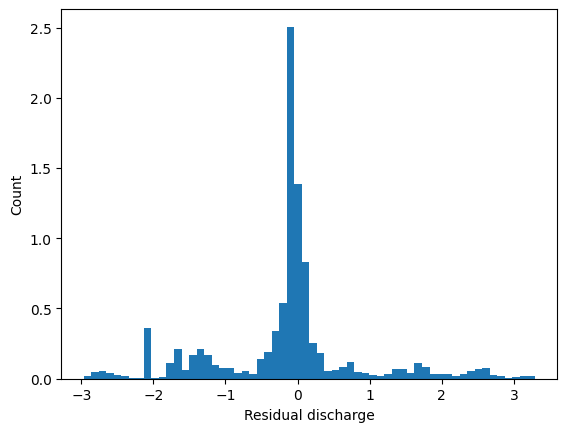

In [30]:
plt.hist(residual_stage / residual_stage.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual discharge');
plt.show()

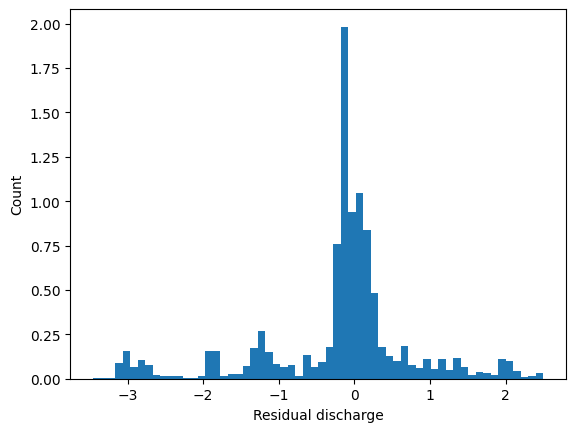

In [31]:
plt.hist(residual_discharge / residual_discharge.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual discharge');
plt.show()